In [3]:
#from sedfitter.filter import Filter
#from sedfitter.convolve import convolve_model_dir
#from sedfitter.convolve import convolve_model_dir_monochromatic
#from astropy import units as u
import numpy as np
from astropy.table import QTable,Table,Column
#from astropy.convolution import convolve, convolve_fft
import re
import matplotlib.pyplot as plt
import random
import math


In [4]:
def unique(lista):
    unicos=[]
    for i in lista:
        if i not in unicos:
            unicos.append(i)
    return unicos

def recta(punto1,punto2,evaluar):
    x1=punto1[0]
    y1=punto1[1]
    x2=punto2[0]
    y2=punto2[1]
    if x2!=x1:
        m=(y2-y1)/(x2-x1)
    if x2==x1:
        pass
    c=y1-(m*x1)
    return [(m*x)+c for x in evaluar]
    
def integrar(datos_entrada,datos_respuesta,limite_minimo,limite_maximo,cantidad_sumas): #terminado y por probar en datos reales

    delta=(limite_maximo-limite_minimo)
    divisiones=float(delta/cantidad_sumas)
    
    
    dominio_1=float(limite_minimo)
    dominio=[dominio_1]
    aprox=len(str(cantidad_sumas))
    while round(float(dominio_1),aprox)!=round(float(limite_maximo),aprox): #funciona generando las divisiones de base n, guardado en la lista dominio.
        dominio_1+=divisiones
        dominio.append(round(dominio_1,aprox))
    #return dominio
    
    coordenadas=[]
    for ejex,ejey in zip(datos_entrada,datos_respuesta): #guarda los conjuntos de coordendas que entran.
        if ejex >= min(dominio) and ejex <= max(dominio):
            for value in dominio:
                if round(float(value))==float(ejex):
                    coordenadas.append([ejex,ejey])
    #return unique(coordenadas)
    
    coordenadas2=unique(coordenadas)
    #indices=0
    
    valores=[]
    dom=[]
    respuestas=[]
    
    for contador in range(0,len(coordenadas2)-1): #correctamente se separan las rectas, y todos los valores en x tienen respuesta en el eje y.
        datos_x=[]
        puntos=[]
        for valores in dominio:
            puntos=[coordenadas2[contador],coordenadas2[contador+1]]
            if valores>=coordenadas2[contador][0] and valores <=coordenadas2[contador+1][0]:
                datos_x.append(valores)
                
        dom.append(datos_x)
        aux=recta(puntos[0],puntos[1],datos_x)
        respuestas.append(aux)    
    #return (dom,respuestas)
    salida=[]
    for recta_x,recta_y in zip(dom,respuestas): #salida correcta.
        c=0
        aux=[]
        while c!=(len(recta_x)-1):
            base=recta_x[c+1]-recta_x[c]
            altura=recta_y[c] ###revisar si el modelo creado sirve y para cual respuesta #c+1, acercamiento superior; c, acercamiento innferior.
            aux.append(base*altura)
            c+=1
        salida.append(aux)
    #return salida
    
    integrado=0
    for lista in salida: #sumatoria final; integración.
        integrado+=sum(lista)
    return integrado


def convolution(espectro,filtro,cantidad_sumas): #ingresan 2 tablas de 2 columnas y m,n filas cada uno, m y n pueden ser iguales o no
    spectra_wl=[]
    spectra_flux=[]
    
    for pair in espectro:
        spectra_wl.append(pair[0])
        spectra_flux.append(pair[1])
        
    filter_wl=[]
    filter_flux=[]
    filter_mixto=[]
    for pair in filtro:
        filter_wl.append(pair[0])
        filter_flux.append(pair[1])
        filter_mixto.append([pair[0],pair[1]])
        
    limite_maximo=max(filter_wl)
    limite_minimo=min(filter_wl)
    
    delta=(limite_maximo-limite_minimo)
    divisiones=float(delta/cantidad_sumas)
    
    #mismo dominio para ambos
    dominio_1=float(limite_minimo)
    dominio=[dominio_1]
    aprox=len(str(cantidad_sumas))
    while round(float(dominio_1),aprox)!=round(float(limite_maximo),aprox): #funciona generando las divisiones de base n, guardado en la lista dominio.
        dominio_1+=divisiones
        dominio.append(round(dominio_1,aprox))

    
    #spectral coords
    coords_spectra=[]
    for ejex,ejey in zip(spectra_wl,spectra_flux): #guarda los conjuntos de coordendas que entran.
        if ejex >= min(dominio) and ejex <= max(dominio):
            for value in dominio:
                if round(float(value))==float(ejex):
                    coords_spectra.append([ejex,ejey])
                  
    coordenadas2=unique(coords_spectra)
    spectra_limitada_wl=[pair[0] for pair in coordenadas2]
    spectra_limitada_flux=[pair[1] for pair in coordenadas2]
    
    #filtro coords
    coords_filtro=[]
    for ejex,ejey in zip(filter_wl,filter_flux):
        for value in dominio:
            if round(float(value))==float(ejex):
                coords_filtro.append([ejex,ejey])
                
    coordenadas3=unique(coords_filtro)
    filtro_limitada_wl=[pair[0] for pair in coordenadas3]
    filtro_limitada_flux=[pair[1] for pair in coordenadas3]
    
    
    #espectro respuesta
    S_wl=[]
    S_respuestas=[]
    
    for contador in range(0,len(coordenadas2)-1): #correctamente se separan las rectas, y todos los valores en x tienen respuesta en el eje y.
        datos_x=[]
        puntos=[]
        for valores in dominio:
            puntos=[coordenadas2[contador],coordenadas2[contador+1]]
            if valores>=coordenadas2[contador][0] and valores <=coordenadas2[contador+1][0]:
                datos_x.append(valores)
                
        S_wl.append(datos_x)
        aux=recta(puntos[0],puntos[1],datos_x)
        S_respuestas.append(aux)
     
    Swl_cont=[]
    SR_cont=[]
    for wl in S_wl:
        Swl_cont+=wl
    for rfl in S_respuestas:
        SR_cont+=rfl
        
    #filtro respuesta  
    F_wl=[]
    F_respuestas=[]
    for contador in range(0,len(coordenadas3)-1):
        datos_x=[]
        puntos=[]
        for valores in dominio:
            puntos=[coordenadas3[contador],coordenadas3[contador+1]]
            if valores >= puntos[0][0] and valores <= puntos[1][0]:
                datos_x.append(valores)
        F_wl.append(datos_x)
        aux2=recta(puntos[0],puntos[1],datos_x)
        F_respuestas.append(aux2)
    
    Fwl_cont=[]
    FR_cont=[]
    for wl in F_wl:
        Fwl_cont+=wl
    for rfl in F_respuestas:
        FR_cont+=rfl
    
    
    #ver el minimo en el flujo para cada valor de longitud de onda
    espectro_final=[]
    for s,f in zip(SR_cont,FR_cont):
        aux=min(s,f)
        espectro_final.append(aux)
    #return [Fwl_cont,FR_cont,espectro_final]


    convol=[]
    c=0
    aux=[]
    while c!=(len(Swl_cont)-1):
        base=Swl_cont[c+1]-Swl_cont[c]
        altura=espectro_final[c] ###revisar si el modelo creado sirve y para cual respuesta #c+1, acercamiento superior; c, acercamiento innferior.
        convol.append(base*altura)
        c+=1
    convolucion=sum(convol)
    return convolucion

In [5]:
#Datos random para ir ajustando la función
x=np.arange(1,11)
y=[random.randrange(0,len(x)) for i in x]
print(x,y)

[ 1  2  3  4  5  6  7  8  9 10] [2, 1, 6, 9, 8, 3, 4, 9, 7, 4]


In [6]:
ak=Table()
ak['alpha']=x
ak['beta']=y

fili=Table()
fili['1']=[3,4,5,6]
fili['2']=[0,3,5,2]

In [7]:
cantidad_sumas=int(input('>'))
a=(convolution(ak,fili,cantidad_sumas))


>100


In [8]:
a

8.969400000000002

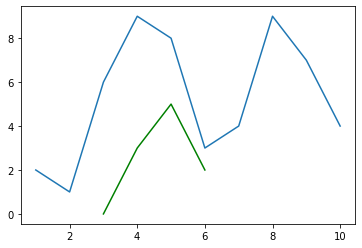

In [9]:
plt.plot((ak['alpha']),(ak['beta']))
plt.plot(fili['1'],fili['2'],'g')

#plt.plot(a[0],a[2],'r')
plt.show()

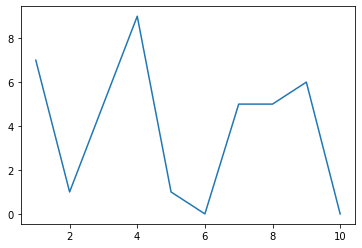

In [29]:
plt.plot(x,y)
plt.show()

In [340]:
#test 01, triangulo bajo recta (0,0),(10,10), valor integrado = 50[u]
x=[0,10]
y=[0,10]
w=int(input('Indique el total de separaciones de datos (los rectangulos) >'))
n=[i for i in range(1,w)]
aux=[]
for value in n:
    aux.append(integrar(x,y,min(x),max(x),value))
aux[len(aux)-1]

>1000


49.949945

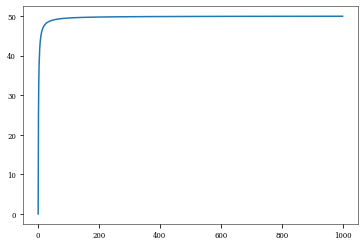

In [341]:
#grafico de aproximación al numero real en funcion del indice de separación dado
plt.plot(n,aux)
plt.show()

0